<a href="https://colab.research.google.com/github/Mathias1232/comp215/blob/main/League_API_Project_Mathias_Stiasny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project is one inspired by my passion for games. The project implements a network-based model to analyze and visualize social connections between players in ranked matches of League of Legends. Using match history data from the Riot API, the model identifies recurring teammates, calculates shared game frequency and win rates, and constructs a graph where:

- Nodes represent individual players.

- Edges represent recurring relationships (i.e., multiple games played together).

- Edge weights represent the number of games played and shared winrate.

- The central node is the main player, and the layout reflects relationship strength.

We enhance the model by recursively including second-degree connections — recurring teammates of recurring teammates — creating a localized social network that reveals patterns in collaboration and performance.

The project had to be scaled down more than I had hoped due to API call limits and processing time. Ideally this could have gone 3 layers deep looking at a users teammates, teammates, teammates and making a large interconnected web. In addition it would have been nice to look at a larger sample of games. However I am satisfied with the end result and it is one that can be scaled up quite easily with the changes of a few variables and functions if there is ever an opportunity to remove the limit of API calls and get a much more powerful system. This project uses many libraries, such as NetworkX which we have used in class to model information. It also uses classes, functions, and also self-constructed dictionaries to improve efficiency. It has been segmented in stages to hopefully make it easier to communicate the process of this project and what it is all about.

P.S. Some use of AI was used mainly to trouble shoot issues and understand the functionality of things better.

This portion contains all the imports necessary to peroform the tasks required in this project. In addition this portion contains global variables such as the API key used to get requests as well as lists containing different regions and platforms to choose from based on where the player is located.

In [27]:
import datetime, json, requests
from pprint import pprint
from matplotlib import pyplot as plt
from matplotlib import offsetbox
# from championID import champion_dict
# from itemID import item_dict
import numpy as np
from io import BytesIO
from PIL import Image
import networkx as nx
import time
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

API_KEY = "RGAPI-0ea0ecaf-9250-41e8-bc16-85894dffa6ad"

# Platform Routing Values
platforms = ['BR1', 'EUN1', 'EUW1', 'JP1', 'KR', 'LA1', 'LA2', 'NA1', 'OC1', 'TR1', 'RU', 'SG2', 'TW2', 'VN2']
platform = platforms[7]

# Regional Routing Values
regions = ['AMERICAS', 'ASIA', 'EUROPE', 'SEA']
region = regions[0]

Below are dictionaries I have created by accessing Riot's website where they store ID's and data about other parts of the game such as Items, Champions, etc. These dictionaries are vital in order to identify champions and items as the API only returns ID's and to put names to those ID's I made dictionaries whith the keys as their ID and Names as the values.

In [24]:
# Fetch the champion data from the provided URL
url = "https://ddragon.leagueoflegends.com/cdn/15.7.1/data/en_US/champion.json"
response = requests.get(url)
data = response.json()

# Extract the 'data' field containing champion information
champions = data['data']

# Create a dictionary with champion id as the key, and champion name as the value
champion_dict = {champion_info['key']: champion_info['name'] for champion_info in champions.values()}



# Fetch the item data from the provided URL
url = "https://ddragon.leagueoflegends.com/cdn/15.7.1/data/en_US/item.json"
response = requests.get(url)
data = response.json()

# Extract the 'data' field containing item information
items = data['data']

# Create a dictionary with item id as the key, and item name as the value
item_dict = {itemID: items[itemID]['name'] for itemID in items}
item_dict['0'] = 'No Item'

Below is my original code I used to understand the API calls and get different information. Similar structures can be found within the classes and functions in this project as I used them referencing these initial notes. Up until the last test I had been uncommenting portions of this code to test various things and troubleshoot.

The code below contains API calls and structures to retrieve information of a user, first getting their puuid (used in most other API requests). The code following is used to retrieve ranked information, match ID's, and match Data using the Match ID's.

In [28]:
NAME = "Nickmjs"
TAG = "Waku"

# Account info - puuid
urlAcc = f'https://{region}.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{NAME}/{TAG}?api_key={API_KEY}'
responseAcc = requests.request("GET", urlAcc, headers={}, data={})
dataAcc = json.loads(responseAcc.text)
puuid = str(dataAcc['puuid'])

# # Summoner info - encryptedid, icon, level
# urlSummoner = f'https://{platform}.api.riotgames.com/lol/summoner/v4/summoners/by-puuid/{puuid}?api_key={API_KEY}'
# responseSummoner = requests.request("GET", urlSummoner, headers={}, data={})
# dataSummoner = json.loads(responseSummoner.text)
# id = dataSummoner['id']

# # Ranked Info
# urlRanked = f'https://{platform}.api.riotgames.com/lol/league/v4/entries/by-summoner/{id}?api_key={API_KEY}'
# resposneRanked = requests.request("GET", urlRanked, headers={}, data={})
# dataRanked = json.loads(resposneRanked.text)
# rank = f"{dataRanked[0]['tier']} {dataRanked[0]['rank']}, {dataRanked[0]['leaguePoints']} LP"
# winrate = f"Wins: {dataRanked[0]['wins']}, Losses: {dataRanked[0]['losses']}, winrate: {round(((dataRanked[0]['wins']/(dataRanked[0]['wins']+dataRanked[0]['losses']))*100), 2)}%"

# Match ID list
# For Ranked Solo Duo
# Queue = 420 Type = ranked
# For summoners rift 5v5
# Queue = 400 Type = normal
# For ranked flex
# Queue = 440 Type = ranked
# urlMatchID = f'https://{region}.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?queue=440&type=ranked&start=0&count=20&api_key={API_KEY}'
# responseMatchID = requests.request("GET", urlMatchID, headers={}, data={})
# listMatchID = json.loads(responseMatchID.text)

# # Match information
# urlMatchInfo = f'https://{region}.api.riotgames.com/lol/match/v5/matches/{listMatchID[0]}?api_key={API_KEY}'
# responseMatchInfo = requests.request("GET", urlMatchInfo, headers={}, data={})
# dataMatchInfo = json.loads(responseMatchInfo.text)
# # Use queue id key to filter from list of matches
# queueId = dataMatchInfo['info']['queueId']

Below is code that can be used to plot a users mastery level on all champions they have played. By testing different users you can see who is a one-trick, a player that tends to stick to one champion, or players who like to play many champions. These differences can be easily identified by how skewed the graph is.

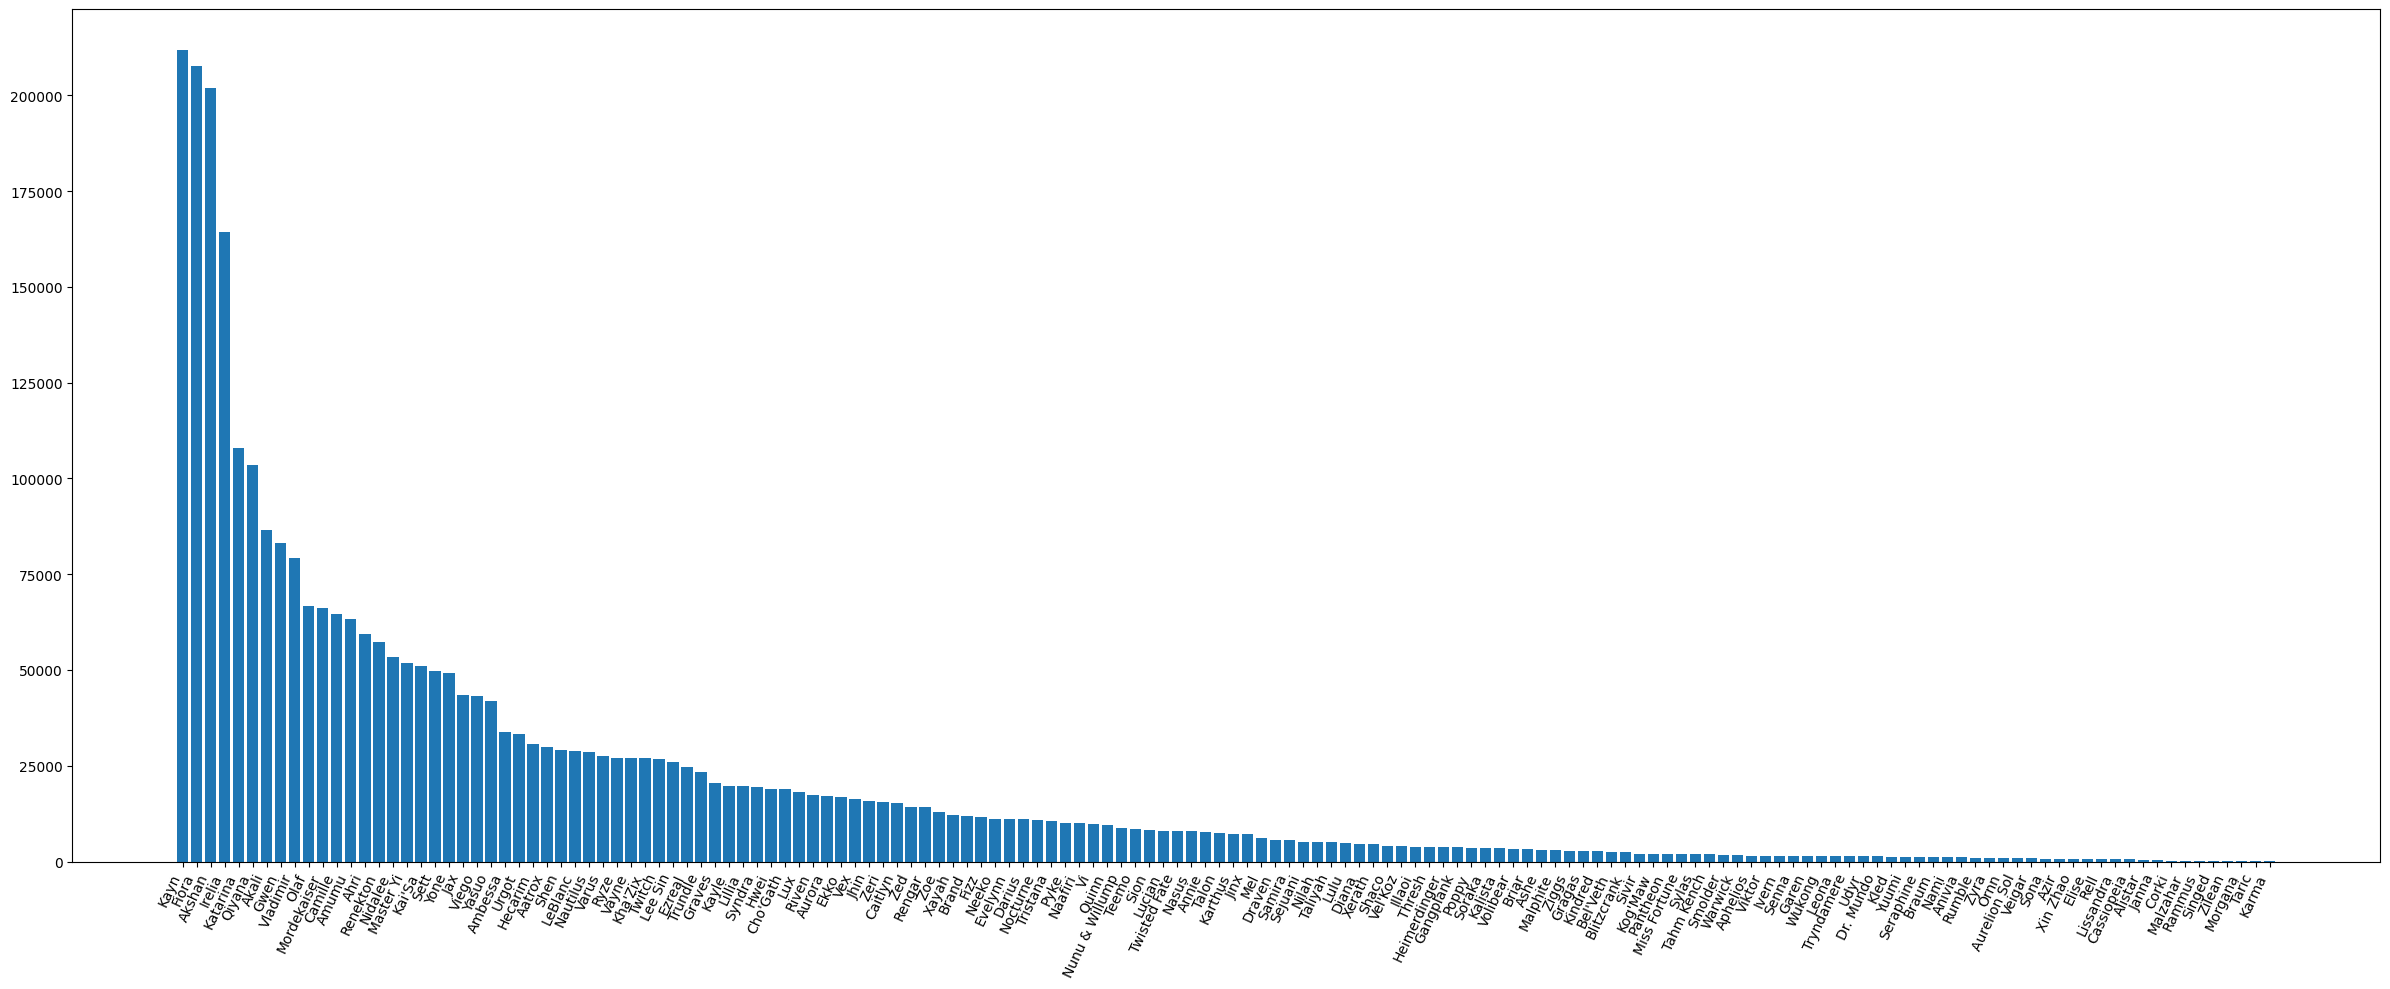

In [ ]:
# Champion mastery
urlMastery = f'https://{platform}.api.riotgames.com/lol/champion-mastery/v4/champion-masteries/by-puuid/{puuid}?api_key={API_KEY}'
responseMastery = requests.request("GET", urlMastery, headers={}, data={})
dataMastery = json.loads(responseMastery.text)
summonerMasteries = [(champion_dict[str(item['championId'])], item['championPoints']) for item in dataMastery]
champs = [item[0] for item in summonerMasteries]
points = [item[1] for item in summonerMasteries]

plt.figure(figsize=(24, 10))
plt.bar(champs, points)
plt.gca().yaxis.get_major_formatter().set_scientific(False)
plt.xticks(range(len(champs)), champs, rotation=65, ha="right")
plt.tight_layout()
plt.show()

Here is the first major class. This is the player class used to create a player and this is used throughout the project. It contains vital information, namely the puuid of a user which is used in the following classes and their methods. It also contains things such as a Players level, their iconID, rank, and Winrate. These methods are used when displaying the NetworkX graph on the side to show additional player info.

In [29]:
class Player:
  '''
  A class represeting a users League of Legends account information

  Args:
      name (str): Users in-game username
      tag (str): Users in-game tag
  '''
  def __init__(self, name, tag):
    '''
    Initializes users name and tag from input, then uses API calls to initialize their puuid and encrypted id
    which are used in following methods to get more information using more API calls
    '''
    # Initialize player name and tag
    self.name = name
    self.tag = tag

    # use player name and tag to get and initialize puuid
    urlAcc = f'https://{region}.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{name}/{tag}?api_key={API_KEY}'
    responseAcc = requests.request("GET", urlAcc, headers={}, data={})
    dataAcc = json.loads(responseAcc.text)

    self.puuid = str(dataAcc['puuid'])

    # use puuid to get and initialize ecrypted id
    urlSummoner = f'https://{platform}.api.riotgames.com/lol/summoner/v4/summoners/by-puuid/{self.puuid}?api_key={API_KEY}'
    responseSummoner = requests.request("GET", urlSummoner, headers={}, data={})
    dataSummoner = json.loads(responseSummoner.text)

    self.id = dataSummoner['id']

  def getName(self):
    '''
    Returns users name
    '''
    return self.name

  def getLevel(self):
    '''
    Uses puuid to get level of users account and return
    '''
    urlSummoner = f'https://{platform}.api.riotgames.com/lol/summoner/v4/summoners/by-puuid/{self.puuid}?api_key={API_KEY}'
    responseSummoner = requests.request("GET", urlSummoner, headers={}, data={})
    dataSummoner = json.loads(responseSummoner.text)
    self.level = dataSummoner['summonerLevel']
    return self.level

  def getIcon(self):
    '''
    Uses puuid to get icon id of users account and return
    '''
    urlSummoner = f'https://{platform}.api.riotgames.com/lol/summoner/v4/summoners/by-puuid/{self.puuid}?api_key={API_KEY}'
    responseSummoner = requests.request("GET", urlSummoner, headers={}, data={})
    dataSummoner = json.loads(responseSummoner.text)
    self.icon = dataSummoner['profileIconId']
    return self.icon

  def getRank(self):
    '''
    Uses encryped id (id) to get ranked information of account and return in a nice format
    '''
    urlRanked = f'https://{platform}.api.riotgames.com/lol/league/v4/entries/by-summoner/{self.id}?api_key={API_KEY}'
    resposneRanked = requests.request("GET", urlRanked, headers={}, data={})
    dataRanked = json.loads(resposneRanked.text)
    flex = 0
    solo = 1
    gameMode = flex
    self.rank = f"{dataRanked[gameMode]['tier']} {dataRanked[gameMode]['rank']}, {dataRanked[gameMode]['leaguePoints']} LP"
    return self.rank

  def getWinrate(self):
    '''
    Uses encrypted id (id) to get ranked information, then calculate and return winrate
    '''
    urlRanked = f'https://{platform}.api.riotgames.com/lol/league/v4/entries/by-summoner/{self.id}?api_key={API_KEY}'
    resposneRanked = requests.request("GET", urlRanked, headers={}, data={})
    dataRanked = json.loads(resposneRanked.text)
    flex = 0
    solo = 1
    gameMode = flex
    self.winrate = f"{dataRanked[gameMode]['wins']} Wins, {dataRanked[gameMode]['losses']} Losses, Winrate: {round(((dataRanked[gameMode]['wins']/(dataRanked[gameMode]['wins']+dataRanked[gameMode]['losses']))*100), 2)}%"
    return self.winrate

The following classes are to do with a Players Matches. The first takes a Player object as an input and then has methods to retrieve match ID's which is then used in the following method. In order to do this (and a lot of the things in the project) it took a lot of time looking at the poorly formatted API information and find ways to extract it. In this case match information could only be exracted on a per-match basis using individual match ID's so a loop was required. When changing the number of games you were looking at sometimes it would create multiple "info" keys containing match information, this caused issues so I needed to add code that would loop though any instances of "info" adn then retrieve the match info and compile it into one list called flattened_matches. These methods are extremely important in getting match info to find teammates played with and match results to make nodes on the NetworkX graph.

In [30]:
class Matches(Player):
  '''
  A class representing a list of a users matches

  Args:
      Player (class): The users Player object
  '''
  def __init__(self, name, tag):
    '''
    Initializes the user's name, tag, puuid, and encrypted id using API calls.
    '''
    super().__init__(name, tag)

  def getMatchID(self, queue, type, count):
    '''
    Retrieves a list of match IDs for the user.

    Args:
      queue (str): The queue type (e.g., '420' for ranked solo/duo).
      type (str): The match type (e.g., 'ranked').
      count (str): The number of matches to retrieve.

    Returns:
      list: A list of match IDs.
    '''
    urlMatchID = f'https://{region}.api.riotgames.com/lol/match/v5/matches/by-puuid/{self.puuid}/ids?queue={queue}&type={type}&start=0&count={count}&api_key={API_KEY}'
    responseMatchID = requests.request("GET", urlMatchID, headers={}, data={})
    listMatchID = json.loads(responseMatchID.text)
    return listMatchID

  def getMatchInfo(self, listMatchID):
    '''
    Retrieves detailed information for a list of matches.

    Args:
      listMatchID (list): A list of match IDs.

    Returns:
      list: A list of match information dictionaries.
    '''
    matches = []
    for match in listMatchID:
      urlMatchInfo = f'https://{region}.api.riotgames.com/lol/match/v5/matches/{match}?api_key={API_KEY}'
      responseMatchInfo = requests.request("GET", urlMatchInfo, headers={}, data={})
      dataMatchInfo = json.loads(responseMatchInfo.text)
      matches.append(dataMatchInfo)

    flattened_matches = []
    for match in matches:
      if 'info' in match:
        flattened_matches.append(match['info'])
    return flattened_matches

class MatchInfo:
  '''
  Represents match information for a single player in a single match.

  Args:
    name (str): The player's in-game username.
    matchInfo (dict): A dictionary containing detailed information about the match.

  Attributes:
    name (str): The player's in-game username.
    matchInfo (dict): A dictionary containing detailed information about the match.
    userMatchInfo (dict): A dictionary containing information specific to the player in the match.
  '''
  def __init__(self, name, matchInfo):
    '''
    Initializes the MatchInfo object with player name and match information.
    '''
    self.name = name
    self.matchInfo = matchInfo
    for participant in self.matchInfo['participants']:
      if participant['riotIdGameName'] == self.name:
        self.userMatchInfo = participant

  def getItems(self):
    '''
    Retrieves the items used by the player in the match.

    Returns:
      dict: A dictionary mapping item slots (e.g., 'Item 0', 'Item 1') to item names.
    '''
    items = {}
    for i in range(7):
      key = str(self.userMatchInfo[f'item{i}'])
      items[f'Item {i}'] = item_dict[key]
    return items

  def getResult(self):
    '''
    Determines the result of the match for the player (Win or Loss).

    Returns:
      str: 'Win' if the player won the match, 'Loss' otherwise.
    '''
    if self.userMatchInfo['win']:
      return "Win"
    else:
      return "Loss"

  def getKDA(self):
    '''
    Calculates and returns the player's KDA (Kills/Deaths/Assists) for the match.

    Returns:
      str: A string representing the player's KDA in the format 'Kills/Deaths/Assists, KDA of X:1'
           or 'Kills/Deaths/Assists, Perfect KDA' if the player had zero deaths.
    '''
    if self.userMatchInfo['deaths'] != 0:
      return f"{self.userMatchInfo['kills']}/{self.userMatchInfo['deaths']}/{self.userMatchInfo['assists']}, KDA of {round((self.userMatchInfo['assists']+self.userMatchInfo['kills'])/self.userMatchInfo['deaths'], 2)}:1"
    else:
      return f"{self.userMatchInfo['kills']}/{self.userMatchInfo['deaths']}/{self.userMatchInfo['assists']}, Perfect KDA"

Below is part of my original code used to figure out how to test methods but more importantly figure out how to get an Icon png using an icon ID. These methods are used in the NetworkX graph to display a Players Icon above their stats alongisde the nodes and rest of the plot.

In [ ]:
# Nickmjs = Player('Nickmjs', 'WAKU')
# NickmjsMatches = Matches('Nickmjs', 'WAKU')
# matchIds = NickmjsMatches.getMatchID('420', 'ranked', '1')
# Nickmjsinfo = NickmjsMatches.getMatchInfo(matchIds)
# NickmjsMatchInfo = MatchInfo('Nickmjs', Nickmjsinfo[0])
# print(NickmjsMatchInfo.getKDA())
# print(Nickmjs.getWinrate())
# print(Nickmjs.getRank())

# PROFILE ICON
# https://ddragon.leagueoflegends.com/cdn/15.7.1/img/profileicon/935.png

# ITEM ICON
# https://ddragon.leagueoflegends.com/cdn/15.7.1/img/item/1001.png

# iconImageUrl = f'https://ddragon.leagueoflegends.com/cdn/15.7.1/img/profileicon/{Nickmjs.getIcon()}.png'
# responseIconImage = requests.get(iconImageUrl)
# iconImage = Image.open(BytesIO(responseIconImage.content))
# plt.imshow(iconImage)
# plt.axis('off')  # Hide axes
# plt.show()

This function is one of the most important functions in this project. It is one that extracts teammates from your match information and filters out players who have played with you less than the minimum stated number of games. If there was no filter than you would have thousands of players that you have played with one time and this would not be useful. Additionally this function simultanesouly adds player information into the reccuring teammates dict which contains games played with them, wins with them, and other information.

In [31]:
def extract_recurring_teammates(player_name, match_data, min_games=2):
  """
  Extracts recurring teammates (same teamId) and calculates winrate, including player tags.

  Args:
    player_name (str): Your Riot ID (e.g., "Nickmjs")
    match_data (list): List of match dictionaries from getMatchInfo()
    min_games (int): Minimum number of games together to count as recurring

  Returns:
    dict: {
      teammate_name: {
        "games": int,
        "wins": int,
        "winrate": float,
        "tag": str  # Added the tag here
        }
    }
  """
  teammate_stats = {}

  for match in match_data:
    participants = match['participants']

    # Find yourself in the match
    my_data = next(p for p in participants if p['riotIdGameName'] == player_name)

    my_team_id = my_data['teamId']
    my_win = my_data['win']

    # Look for your teammates
    for p in participants:
      if p['teamId'] == my_team_id and p['riotIdGameName'] != player_name:
        teammate_name = p['riotIdGameName']
        teammate_tag = p['riotIdTagline']  # Get the tag of the teammate

        if teammate_name not in teammate_stats:
          teammate_stats[teammate_name] = {"games": 0, "wins": 0, "tag": teammate_tag}

        teammate_stats[teammate_name]["games"] += 1
        if my_win:
          teammate_stats[teammate_name]["wins"] += 1

  # Filter and calculate winrates for recurring teammates
  recurring_teammates = {}

  for name, stats in teammate_stats.items():
    if stats["games"] >= min_games:
      winrate = round(100 * stats["wins"] / stats["games"], 2)
      recurring_teammates[name] = {
        "games": stats["games"],
        "wins": stats["wins"],
        "winrate": winrate,
        "tag": stats["tag"]  # Include tag in the result
      }

  return recurring_teammates

This was a function I was going to use to display each node as the icon of each player. It would create player objects for your teammates and then use the getIcon function to get their icons. Unfortunately this would use way too much processing as it is making many player objects and many API calls and ultimately was out of scope. Though on a smaller scale (using less teammates) it was proven to work.

In [ ]:
# def create_player_objects_and_get_icons(recurring_teammates):
#     player_objects = {}

#     # Create Player objects and fetch their icons
#     for teammate, stats in recurring_teammates.items():
#         player = Player(teammate, stats['tag'])  # Create Player object using name and tag
#         icon_id = player.getIcon()  # Get icon using the getIcon method
#         player_objects[teammate] = {
#             'icon_id': icon_id,
#             'games': stats['games'],
#             'wins': stats['wins'],
#             'winrate': stats['winrate'],
#             'tag': stats['tag']
#         }

#     return player_objects

This function was extremely important in simplifying my large function "visualize_teammates_with_closest_players". This function is one that goes one step deeper into displaying the network of people who have played together. In order to save time and exceeding API call limits this function gets the closest users to the Player basd on a chosen minimum amount of games played with them. For example, when looking at a players past 100 games, you want to obtain users the player has played with at least 5 times or more, you can use this function.

In [8]:
def get_closest_teammates(recurring_teammates, min_games=2):
  """
  Filters the closest teammates (those with at least `min_games` games played with the player).

  Args:
    recurring_teammates (dict): Dictionary of recurring teammates for the main player.
    min_games (int): Minimum number of games to consider a teammate as close.

  Returns:
    dict: Closest teammates who have played at least `min_games` games.
  """
  closest_teammates = {name: stats for name, stats in recurring_teammates.items() if stats['games'] >= min_games}
  return closest_teammates


This function is used to get match data for all of the closest teammates obtained by the previous function. This is important when going one step deeper and trying to find people that your teammates have played with and graphing it. This function has a 2 minute delay between retrieving users matche info as the API has a limit of 100 requests per 2 minutes.

In [9]:
def get_match_data_for_closest_players(closest_teammates):
  """
  Fetches the most recent 100 matches for each closest teammate and returns the match data.

  Args:
    closest_teammates (dict): Dictionary of closest teammates to the main player.

  Returns:
    dict: A dictionary with player names as keys and their match data as values.
  """
  closest_players_data = {}

  for teammate in closest_teammates:
    # Get match data for each closest teammate (100 recent ranked games)
    teammate_matches = Matches(teammate, closest_teammates[teammate]['tag'])
    match_ids = teammate_matches.getMatchID(queue='440', type='ranked', count=100)
    match_data = teammate_matches.getMatchInfo(match_ids)

    # Store the match data for each closest player
    closest_players_data[teammate] = match_data
    time.sleep(120)
  return closest_players_data

This function is used for the first level of depth when plotting the Player and teammates. It uses the reccuring teammates dictionary to extract players names, games played, and wins with you to make nodes. The edges are weighed by games played with the Player as well as the distance of the nodes. Win % and games played are plotted on the edges to display statistics between players. The function only plots your reccuring teammates and is not yet going deeper into who they have played with. It also plots the player icon, rank, name, and winrate on the side as a cool profile type display.

In [ ]:
def visualize_teammates(recurring_teammates, playerObject):
  """
  Visualizes the recurring teammates with the player at the center and overlays the main player's icon and stats on the left.

  Args:
      recurring_teammates (dict): Dictionary of teammate stats
      playerObject (Player): The Player object representing the main player
  """
  player_name = playerObject.getName()

  # Set up the figure with 2 subplots: one for the graph and one for the stats
  fig, ax = plt.subplots(figsize=(14, 8), ncols=2, gridspec_kw={'width_ratios': [0.4, 0.6]})

  # Create the graph
  G = nx.Graph()

  # Add the main player node
  G.add_node(player_name, size=3000, color='lightblue')

  # Add edges between the player and each teammate
  for teammate, stats in recurring_teammates.items():
    G.add_node(teammate, size=2000, color='skyblue')
    G.add_edge(
      player_name,
      teammate,
      weight=stats['games'],
      label=f"{stats['games']} games\n{stats['winrate']}%"
    )

  # Node sizes and colors
  node_sizes = [G.nodes[n]['size'] for n in G.nodes()]
  node_colors = [G.nodes[n]['color'] for n in G.nodes()]

  # Edge weights and labels
  edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
  edge_labels = {(u, v): G[u][v]['label'] for u, v in G.edges()}

  # Position the player at the center
  pos = nx.spring_layout(G, k=3, seed=42)
  # Ensure player is at (0,0)
  if G.nodes():
    pos[player_name] = np.array([0, 0])

  # Draw the graph on the right subplot
  ax[1].set_title(f"Recurring Teammates for {player_name}", fontsize=14)
  nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    alpha=0.9,
    ax=ax[1]
  )

  # Draw edges with varying widths
  nx.draw_networkx_edges(
    G, pos,
    width=[0.5 + w*0.2 for w in edge_weights],  # Scale edge widths
    edge_color='gray',
    alpha=0.6,
    ax=ax[1]
  )

  # Draw labels
  nx.draw_networkx_labels(
    G, pos,
    font_size=10,
    font_weight='bold',
    ax=ax[1]
  )

  # Draw edge labels
  nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_size=8,
    # Place labels in middle of edges
    label_pos=0.5,
    ax=ax[1]
  )

  # Fetch the main player's icon ID using the getIcon method
  icon_id = playerObject.getIcon()

  # Get the icon image based on the icon ID
  icon_url = f"https://ddragon.leagueoflegends.com/cdn/15.7.1/img/profileicon/{icon_id}.png"
  response = requests.get(icon_url, timeout=5)
  icon = Image.open(BytesIO(response.content))

  # The original icon resolution
  original_width, original_height = icon.size

  # Set the zoom factor to scale the image (use 0.2 for 20% of the original size, adjust as needed)
  zoom_factor = 0.4
  imagebox = AnnotationBbox(
    OffsetImage(icon, zoom=zoom_factor),
    # Positioning relative to the left box (centered)
    (0.5, 0.8),
    frameon=False,
    xycoords='axes fraction'
  )
  ax[0].add_artist(imagebox)

  # Add the player's stats on the left side below the icon
  player_stats_text = f"Name: {player_name}\n"
  player_stats_text += f"Level: {playerObject.getLevel()}\n"
  player_stats_text += f"Rank: {playerObject.getRank()}\n"
  player_stats_text += f"Stats: {playerObject.getWinrate()}%"

  # Position the text closer to the icon
  ax[0].text(0.5, 0.62, player_stats_text, ha='center', va='center', fontsize=12, wrap=True, transform=ax[0].transAxes)

  # Remove axes for the left subplot
  ax[0].axis('off')

  # Adjust layout to make room for the graph and the player info
  plt.tight_layout()

  # Save and show the plot
  plt.savefig('teammates_network_with_icon_and_stats.png', dpi=300, bbox_inches='tight')
  print("Graph saved as teammates_network_with_icon_and_stats.png")
  plt.show()

This function is the one that goes one step deeper than the previous. It uses the same methods for edge weights, labels, etc, however it has the added functionality of using the get_closest_teammates function and get_match_data_for_closest_players fucntion to get the match information for those tammates closest to you and add the teammates from their games into the collection of nodes as well. This is the capstone of this project and it is a useful tool in visualizing the interconnectivity between players and also how more games played wiht people affects your winrate. I would like to add that without the restriction of API calls this function could be modified to go even further to a depth of 3 levels. Additionally when graphing I have been using the players most revent 100 games and only the couple closest teammates (around 3) and their 100 most recent games. Dping this already takes up to 10 minutes using delays to avoid API call restrictions. Though one could lower the minimum number of games played with teammates and increase number of games retrieved to get a much braoder picture of the network of players who play with eachother.

In [10]:
def visualize_teammates_with_closest_players(recurring_teammates, playerObject, match_data, min_games=5):
  """
  Visualizes the recurring teammates, including closest players, their recurring teammates, and overlays the main player's icon and stats on the left.

  Args:
    recurring_teammates (dict): Dictionary of recurring teammates for the main player.
    playerObject (Player): The Player object representing the main player.
    match_data (list): List of match dictionaries for extracting new match data.
    min_games (int): Minimum number of games to consider a teammate as close.
  """
  player_name = playerObject.getName()

  # Get closest teammates (those with 5 or more games played)
  closest_teammates = get_closest_teammates(recurring_teammates, min_games)

  # Get match data for the closest players
  closest_players_data = get_match_data_for_closest_players(closest_teammates)

  # Set up the figure with 2 subplots: one for the graph and one for the stats
  fig, ax = plt.subplots(figsize=(14, 8), ncols=2, gridspec_kw={'width_ratios': [0.4, 0.6]})

  # Create the graph
  G = nx.Graph()

  # Add the main player node
  G.add_node(player_name, size=3000, color='lightblue')

  # Add edges between the player and each teammate (main player)
  for teammate, stats in recurring_teammates.items():
    G.add_node(teammate, size=2000, color='skyblue')
    G.add_edge(
      player_name,
      teammate,
      weight=stats['games'],
      label=f"{stats['games']} games\n{stats['winrate']}%"
    )

  # For each closest teammate, get their recurring teammates and add them to the graph
  for closest_teammate in closest_teammates:
    # Extract recurring teammates using the fetched match data
    teammate_recurring = extract_recurring_teammates(closest_teammate, closest_players_data[closest_teammate], min_games)

    # Add the closest teammate to the graph
    G.add_node(closest_teammate, size=2500, color='lightgreen')

    # Add edges between the main player and closest teammate
    G.add_edge(
      player_name,
      closest_teammate,
      weight=closest_teammates[closest_teammate]['games'],
      label=f"{closest_teammates[closest_teammate]['games']} games\n{closest_teammates[closest_teammate]['winrate']}%"
    )

    # Add edges between the closest teammate and their recurring teammates
    for teammate, stats in teammate_recurring.items():
      G.add_node(teammate, size=2000, color='skyblue')
      G.add_edge(
        closest_teammate,
        teammate,
        weight=stats['games'],
        label=f"{stats['games']} games\n{stats['winrate']}%"
        )

  # Node sizes and colors
  node_sizes = [G.nodes[n]['size'] for n in G.nodes()]
  node_colors = [G.nodes[n]['color'] for n in G.nodes()]

  # Edge weights and labels
  edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
  edge_labels = {(u, v): G[u][v]['label'] for u, v in G.edges()}

  # Position the player at the center
  pos = nx.spring_layout(G, k=3, seed=42)
   # Ensure player is at (0,0)
  if G.nodes():
    pos[player_name] = np.array([0, 0])

  # Draw the graph on the right subplot
  ax[1].set_title(f"Recurring Teammates for {player_name}", fontsize=14)
  nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    alpha=0.9,
    ax=ax[1]
  )

  # Draw edges with varying widths
  nx.draw_networkx_edges(
    G, pos,
    # Scale edge widths
    width=[0.5 + w*0.2 for w in edge_weights],
    edge_color='gray',
    alpha=0.6,
    ax=ax[1]
  )

  # Draw labels
  nx.draw_networkx_labels(
    G, pos,
    font_size=10,
    font_weight='bold',
    ax=ax[1]
  )

  # Draw edge labels
  nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_size=8,
    # Place labels in middle of edges
    label_pos=0.5,
    ax=ax[1]
  )

  # Fetch the main player's icon ID using the getIcon method
  icon_id = playerObject.getIcon()

  # Get the icon image based on the icon ID
  icon_url = f"https://ddragon.leagueoflegends.com/cdn/15.7.1/img/profileicon/{icon_id}.png"
  response = requests.get(icon_url, timeout=5)
  icon = Image.open(BytesIO(response.content))

  # The original icon resolution
  original_width, original_height = icon.size

  # Set the zoom factor to scale the image (use 0.2 for 20% of the original size, adjust as needed)
  zoom_factor = 0.4
  imagebox = AnnotationBbox(
    OffsetImage(icon, zoom=zoom_factor),
    # Positioning relative to the left box (centered)
    (0.5, 0.8),
    frameon=False,
    xycoords='axes fraction'
  )
  ax[0].add_artist(imagebox)

  # Add the player's stats on the left side below the icon
  player_stats_text = f"Name: {player_name}\n"
  player_stats_text += f"Level: {playerObject.getLevel()}\n"
  player_stats_text += f"Rank: {playerObject.getRank()}\n"
  player_stats_text += f"Stats: {playerObject.getWinrate()}%"

  # Position the text closer to the icon
  ax[0].text(0.5, 0.62, player_stats_text, ha='center', va='center', fontsize=12, wrap=True, transform=ax[0].transAxes)

  # Remove axes for the left subplot
  ax[0].axis('off')

  # Adjust layout to make room for the graph and the player info
  plt.tight_layout()

  # Save and show the plot
  plt.savefig('teammates_network_with_closest_players1.png', dpi=300, bbox_inches='tight')
  print("Graph saved as teammates_network_with_closest_players.png")
  plt.show()

Here is code used to test either the 1 level of depth or 2 levels of depth visualization funcitons to graph the networkx graph.

In [32]:
# Example of using the visualization function
Nickmjs = Player('Nickmjs', 'WAKU')
NickmjsMatches = Matches('Nickmjs', 'WAKU')
match_ids = NickmjsMatches.getMatchID(queue='440', type='ranked', count=100)
match_data = NickmjsMatches.getMatchInfo(match_ids)
time.sleep(120)
recurring_teammates = extract_recurring_teammates("Nickmjs", match_data, min_games=2)

# Visualize the recurring teammates with games played and winrate on the edges
#visualize_teammates(recurring_teammates, Nickmjs)
visualize_teammates_with_closest_players(recurring_teammates, Nickmjs, match_data, min_games=4)
# with open("matchInfo.txt", "w") as match_file:
#     pprint(recurring_teammates, stream=match_file)

KeyError: 'puuid'